In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [10]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [11]:
train_good_imgs = load_img_dict('../dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('../dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('../dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('../dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('../dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('../dataset_pruning/val_border_dict.json')

In [4]:
train_good_imgs[0]

{0: {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 50,
  1: 51,
  2: 52,
  3: 53,
  4: 54,
  5: 55,
  6: 56,
  7: 57,
  8: 58,
  9: 59,
  10: 60,
  11: 61,
  12: 62,
  13: 63,
  14: 64,
  15: 65,
  16: 66,
  17: 67,
  18: 68,
  19: 69,
  20: 70,
  21: 71,
  22: 72,
  23: 73,
  24: 74,
  25: 75,
  26: 76,
  27: 77,
  28: 78,
  29: 79,
  30: 80,
  3

In [3]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [4]:
import copy

# Different batches have different borders
def get_borders(tracks, batch_num):
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    for x in range(tracks.X.shape[2]):
        if tracks.X[batch_num][0][x][300] != 0:
            x_min = x - 1
            break
    for x in range(tracks.X.shape[2] - 1, -1, -1):
        if tracks.X[batch_num][0][x][300] != 0:
            x_max = x + 1
            break
    for y in range(tracks.X.shape[3]):
        if tracks.X[batch_num][0][300][y] != 0:
            y_min = y - 1
            break
    for y in range(tracks.X.shape[3] - 1, -1 , -1):
        if tracks.X[batch_num][0][300][y] != 0:
            y_max = y + 1
            break
    return x_min, x_max, y_min, y_max

# all_train_tracks, train_track_info
# tracks = all_train_tracks[0]
# track_info = train_track_info
# We might want to not load "all tracks" and make it a list, eventually, since there is only one track
def det_img_real(tracks, batch, frame, cell):
    cent = tracks.centroids[batch, frame, cell]
    if np.array_equal(cent, np.zeros(2, dtype='float32')):
        return False
    return True
    
# all_train_tracks[0].centroids[90, 70, 404]

# Want to get 'borders' tuple for each batch once
def det_cell_on_border(tracks, batch, frame, cell, borders):
    x_min, x_max, y_min, y_max = borders
    mask_movie_img = tracks.y[batch][frame]
    color = cell + 1
    for x in range(x_min + 1, x_max):
        for width in range(1, 4):
            if mask_movie_img[x][y_min + width] == color or mask_movie_img[x][y_max - width] == color:
                return True
    for y in range(y_min + 1, y_max):
        for width in range(1, 4):
            if mask_movie_img[x_min + width][y] == color or mask_movie_img[x_max - width][y] == color:
                return True
    return False
    

def get_frames_to_split_dict(tracks):
    batches, frames, cells = all_train_tracks[0].centroids.shape[:3]
    
    frames_to_split_dict = {}
    for batch in range(batches):
        frames_to_split_dict[batch] = {}
        for cell in range(cells):
            frames_to_split_dict[batch][cell] = {}
            for frame in range(frames):
                frames_to_split_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in range(cells):
            cell_label = cell + 1
            if len(all_train_tracks[0].lineages[batch][cell_label]['daughters']) != 0:
                cell_frames = all_train_tracks[0].lineages[batch][cell_label]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    frames_to_split_dict[batch][cell][cell_frame] = last_frame - cell_frame + 1
    
    return frames_to_split_dict

def get_good_imgs_dict(tracks):
    # (91, 71, 405, 2)
    batches, frames, cells = tracks.centroids.shape[:3]
    
    good_imgs = {}
    blank_imgs = {}
    border_imgs = {}
    lst_idx_to_pos = {}
    
    for batch in range(batches):
        good_imgs[batch] = {}
        for cell in range(cells):
            good_imgs[batch][cell] = {}
            for frame in range(frames):
                good_imgs[batch][cell][frame] = -1
    blank_imgs = copy.deepcopy(good_imgs)
    border_imgs = copy.deepcopy(good_imgs)
    
    num_good_img = 0
    for batch in range(batches):
        borders = get_borders(tracks, batch)
        for cell in range(cells):
            for frame in range(frames):
                if det_img_real(tracks, batch, frame, cell):
                    if not det_cell_on_border(tracks, batch, frame, cell, borders):
                        good_imgs[batch][cell][frame] = num_good_img
                        lst_idx_to_pos[num_good_img] = (batch, frame, cell)
                        num_good_img += 1
                    else:
                        border_imgs[batch][cell][frame] = 1
                else:
                    blank_imgs[batch][cell][frame] = 1
                
    return good_imgs, blank_imgs, border_imgs, lst_idx_to_pos

# app = track_info['appearances']
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    good_img_list.append(app[batch][frame][cell])
    appearances = np.array(good_img_list)
    return appearances
# When we eliminate images for being blank or on the border, we might want to add them to a list for later inspection

In [5]:
def prepare_dataset(appearances, batch_size=1, buffer_size=256,
                    seed=None):
    app_shape = np.shape(appearances)

    # Appearances not being normalized yet (will have to slightly modify norm function
    # since we don't have this organized by life cycle
    appearances = norm(appearances)

    dataset = tf.data.Dataset.from_tensor_slices((appearances, appearances))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [6]:
%%time
# data loading
with tf.device('/device:CPU:0'):
    path_temp_train_trks = '/training/tracking-nuclear/train.trks'
    all_train_data = [load_trks(path_temp_train_trks)]
    print("All " + str(len(all_train_data)) + " trks are loaded")
    
    all_train_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_train_data]
    print("converted to Track objects")
    
    train_track_info = concat_tracks(all_train_tracks)
    
# 71%

2022-08-03 21:12:14.190406: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 21:12:15.620617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


All 1 trks are loaded


 33%|██████████████▏                            | 30/91 [05:51<13:51, 13.63s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 91/91 [13:35<00:

converted to Track objects
CPU times: user 1h 19min 5s, sys: 1h 30min 6s, total: 2h 49min 12s
Wall time: 25min 24s


In [7]:
%%time
# data loading
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    print("All " + str(len(all_val_data)) + " trks are loaded")
    
    all_val_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_val_data]
    print("converted to Track objects")
    
    val_track_info = concat_tracks(all_val_tracks)

# 78%

All 1 trks are loaded


100%|███████████████████████████████████████████| 27/27 [02:47<00:00,  6.20s/it]


converted to Track objects
CPU times: user 21min 37s, sys: 26min 29s, total: 48min 6s
Wall time: 5min 55s


In [7]:
%%time
train_good_imgs, train_blank_imgs, train_border_imgs, train_lst_idx_to_pos = get_good_imgs_dict(all_train_tracks[0])

CPU times: user 2h 25min 53s, sys: 12.3 s, total: 2h 26min 5s
Wall time: 2h 26min 36s


In [12]:
# Should just call this train_appearances, and same for the latter ones
train_good_img_arr = get_good_img_arr(train_good_imgs, train_track_info['appearances'])

In [10]:
%%time
val_good_imgs, val_blank_imgs, val_border_imgs, val_lst_idx_to_pos = get_good_imgs_dict(all_val_tracks[0])

CPU times: user 33min 17s, sys: 794 ms, total: 33min 17s
Wall time: 33min 17s


In [13]:
%%time
val_good_img_arr = get_good_img_arr(val_good_imgs, val_track_info['appearances'])

CPU times: user 525 ms, sys: 11 s, total: 11.5 s
Wall time: 11.6 s


In [17]:
import json
def save_img_dict(img_dict, file):
    json_file = json.dumps(img_dict)
    f = open(file,"w")
    f.write(json_file)
    f.close()

In [18]:
save_img_dict(train_good_imgs, 'train_appearances_dict.json')
save_img_dict(train_blank_imgs, 'train_blank_dict.json')
save_img_dict(train_border_imgs, 'train_border_dict.json')
save_img_dict(val_good_imgs, 'val_appearances_dict.json')
save_img_dict(val_blank_imgs, 'val_blank_dict.json')
save_img_dict(val_border_imgs, 'val_border_dict.json')

In [ ]:
# Maybe don't use the CPU (although I'm pretty sure it's not, anyways, since the memory used didn't increase)
# But the key could be the batch size
with tf.device('/device:CPU:0'):
    train_dataset = prepare_dataset(train_good_img_arr, batch_size=100)

In [ ]:
%%time
with tf.device('/device:CPU:0'):
    val_dataset = prepare_dataset(val_good_img_arr, batch_size=100)

In [ ]:
# Just save the dictionary next time (getting that takes by far the most time)

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [22]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (64, 64, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(16*16*32, activation=None))
        layers.append(tfkl.Reshape((16,16,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [23]:
vae = VAE(1024, 1, 1e-3)
AE = vae.build_vae_keras_model()

2022-08-02 23:11:16.246029: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 2
model_path = '../models/first_64_64'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

In [19]:
train_good_img_arr.shape

(383800, 64, 64, 1)

In [20]:
val_good_img_arr.shape

(89436, 64, 64, 1)

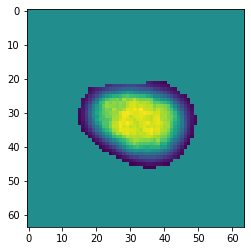

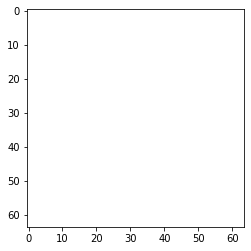

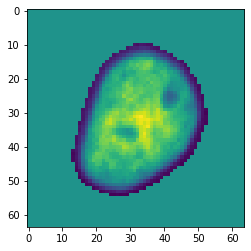

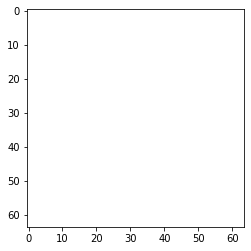

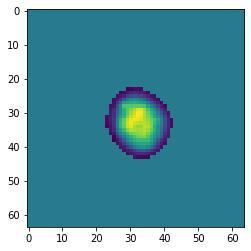

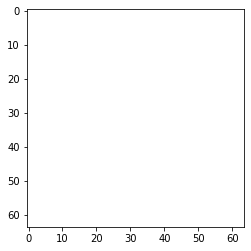

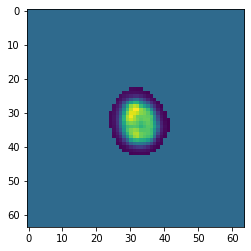

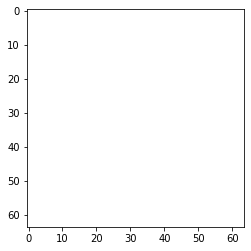

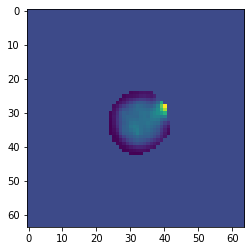

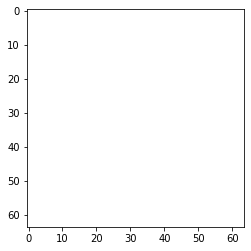

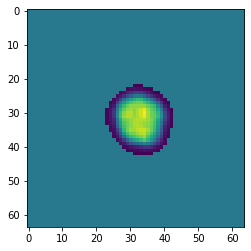

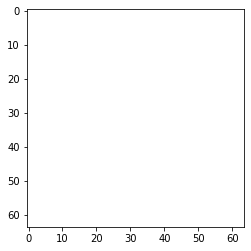

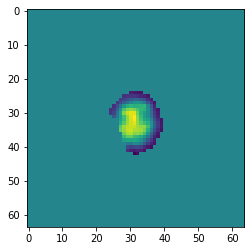

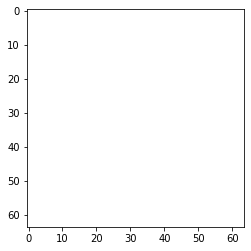

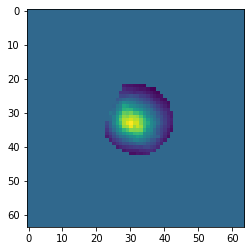

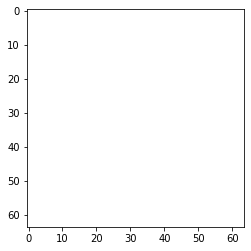

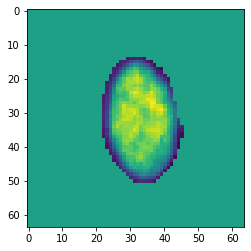

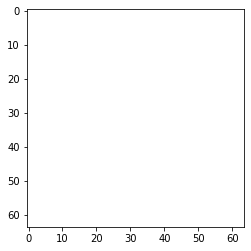

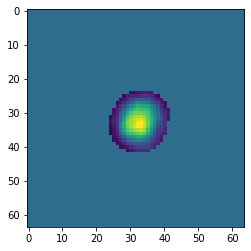

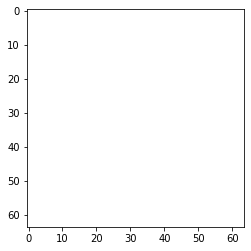

In [17]:
recon_sample = [263403, 234088, 108714, 100465, 187225, 196221, 132592, 287101, 271923, 184110]
import matplotlib.pyplot as plt

for idx in recon_sample:
    x = np.array([train_good_img_arr[idx]])
    xhat = AE(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [18]:
np.set_printoptions(threshold=np.inf)
x = np.array([train_good_img_arr[idx]])
xhat = AE(x).mean()
print(xhat)

tf.Tensor(
[[[[nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]]

  [[nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [nan]
   [na

In [ ]:
# Want to use variables for KL-divergence weight, number of encoder/decoder layers, and number of filters so that
# a grid search can be performed

class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.num_layers = num_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense((side/frac)**2*32, activation=None))
        layers.append(tfkl.Reshape((side/frac,side/frac,32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)